# Titanic Kaggle Dataset - Matheus Maia

Análise do dataset Titanic do Kaggle para seleção.


*   Setup - Imports do Módulos e Download dos Dados
*   EDA - Exploração
*   Feature Engineering - Preparar dados
*   Explorar Modelos
*   Aperfeiçoar Modelo
*   Apresentar Solução



## Setup
Imports necessários. Carregar dataset.

In [ ]:
#Necessário matplotlib mais atualizado
!pip install matplotlib==3.5.1 

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import string

#SKlearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier

assert(matplotlib.__version__ == '3.5.1')

In [ ]:
URL_TRAIN = 'https://drive.google.com/uc?id=159szIgtw6IPs08w9qFp0QZZi5S6_Qnxh'
URL_TEST = 'https://drive.google.com/uc?id=14wGfw4pK6z54RR0kVC3yI9XpG4h85E-u'
train_df_kaggle = pd.read_csv(URL_TRAIN)
test_df_kaggle = pd.read_csv(URL_TEST)

## EDA - Exploração
Tipo, nulos, ausentes, viz e corr.

In [ ]:
vis_df = train_df_kaggle.copy()

In [ ]:
vis_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
vis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
vis_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
vis_df.describe(include=[object]) 

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


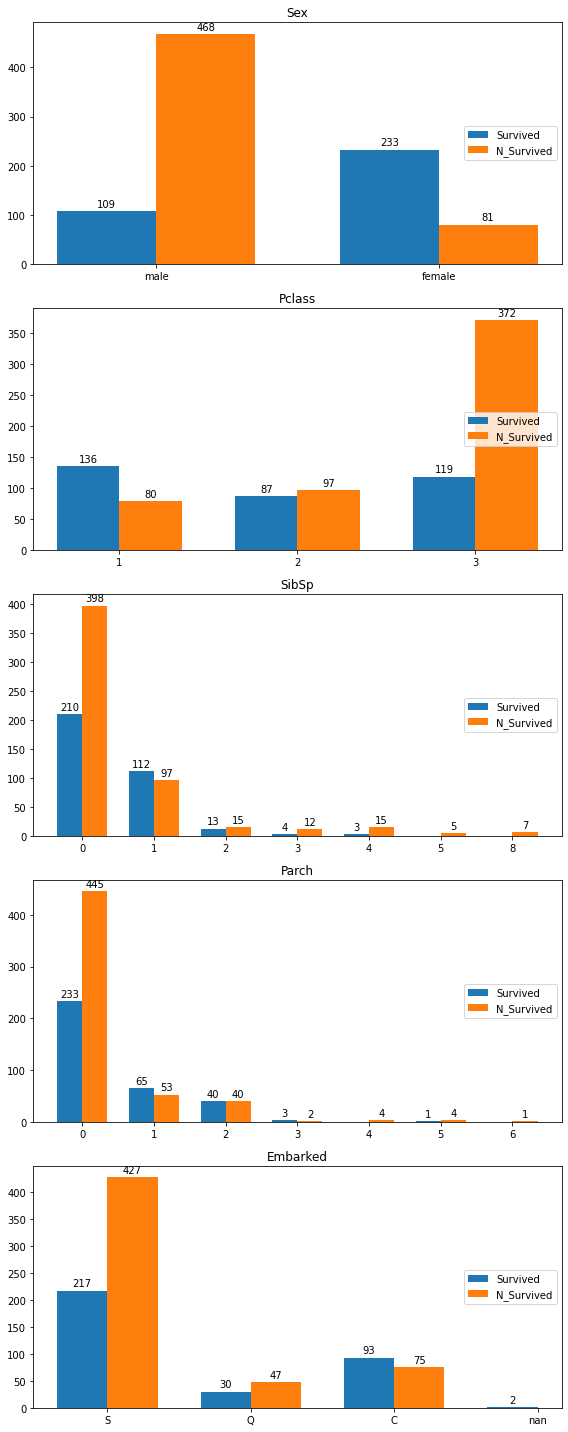

In [ ]:
#Colunas com poucos distinct
coluns_hist = ["Sex", "Pclass", "SibSp", "Parch", "Embarked"]

fig, axs = plt.subplots(len(coluns_hist), 1, figsize=(8,20))

#Para cada coluna
for i, c in enumerate(coluns_hist):
  #Contar survived e n_survived para coluna
  n_survided = vis_df.loc[vis_df["Survived"] == 0, c].value_counts(sort=False, dropna=False)
  survided = vis_df.loc[vis_df["Survived"] == 1, c].value_counts(sort=False, dropna=False)  
  value_counts = pd.DataFrame([n_survided, survided])

  #labels, x, width
  columns = [str(col) for col in value_counts.columns]
  x = np.arange(len(columns))
  width = 0.35

  n_survived_counts = value_counts.iloc[0].tolist()
  survived_counts = value_counts.iloc[1].tolist()
  
  rects1 = axs[i].bar(x - width/2, survived_counts, width, label='Survived')
  rects2 = axs[i].bar(x + width/2, n_survived_counts, width, label='N_Survived')
  
  axs[i].bar_label(rects1, padding=2)
  axs[i].bar_label(rects2, padding=2)
  axs[i].set_title(c)
  axs[i].legend(loc ="right")
  axs[i].set_xticks(x, labels=columns)
  fig.tight_layout()

In [ ]:
#Idade
vis_df["Age_cat"] = pd.cut(vis_df["Age"], bins=[0, 5, 14, 25, 45, 99], labels=["BB", "Cri", "Jov", "Adul", "MaisVelhos"])
n_survided = vis_df.loc[vis_df["Survived"] == 0, "Age_cat"].value_counts(sort=False, dropna=False)
survided = vis_df.loc[vis_df["Survived"] == 1, "Age_cat"].value_counts(sort=False, dropna=False)
value_counts = pd.DataFrame([n_survided, survided],index=["N_S", "S"])
value_counts

,BB,Cri,Jov,Adul,MaisVelhos,NaN
N_S,13,19,145,182,65,125
S,31,14,79,128,38,52


<AxesSubplot:ylabel='Frequency'>

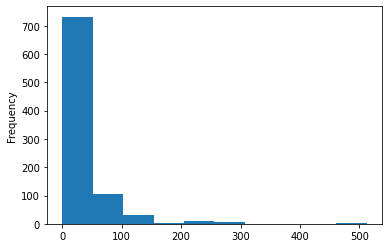

In [ ]:
#Valor do Bilhete
vis_df["Fare"].plot(kind="hist")

In [ ]:
#Corr Matrix
corr_matrix = vis_df.corr()
corr_matrix.style.background_gradient(cmap='Blues').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  This is separate from the ipykernel package so we can avoid doing imports until


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


 

*   Tarifa está concentrado em valores mais baixos com cauda à direita. Possui outliers.
*   Idade, Cabine e Porto tem valores nulos.
*   As características [Sexo], [Bilhete mais caro(Fare ou Class)] e [Ser Criança] parecem importar em Survived.



## Feature Engineering - Preparar dados

In [ ]:
train_pp_df = train_df_kaggle.copy()

### Sugestões [Link Kaggle](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)

Em um link no kaggle existem sugestões de pré processamentos:

> Evidenciar Título, Deck e Tamanho da Família




In [ ]:
def substrings_in_string(big_string, substrings):
  for substring in substrings:
    if str(big_string).find(substring) != -1:
      return substring
  return np.nan

def replace_titles(x):
  title=x['Title']
  if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
    return 'Mr'
  elif title in ['Countess', 'Mme']:
    return 'Mrs'
  elif title in ['Mlle', 'Ms']:
    return 'Miss'
  elif title =='Dr':
    if x['Sex']=='Male':
      return 'Mr'
    else:
      return 'Mrs'
  else:
      return title

In [ ]:
#Adicionar Título
TITLE_LIST=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
train_pp_df['Title']=train_pp_df['Name'].map(lambda x: substrings_in_string(x, TITLE_LIST))

#Restringe Título ('Mr', 'Mrs', 'Miss', 'Master')
train_pp_df['Title']=train_pp_df.apply(replace_titles, axis=1)

In [ ]:
#Adicionar Deck a partir da Cabine
CABIN_LIST = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
train_pp_df['Deck']=train_pp_df['Cabin'].map(lambda x: substrings_in_string(x, CABIN_LIST))

In [ ]:
#Tamanho da Família = SibSp + Parch
train_pp_df['Family_Size']=train_pp_df['SibSp']+train_pp_df['Parch']

### Outras Transformações

*   Categorizar - Idade
*   Logaritmo do Preço
*   Sem Pais (<16 e Parch==0)
*   Com Pais (<16 e Parch!=0)



In [ ]:
#Remover Outlier

<AxesSubplot:ylabel='Frequency'>

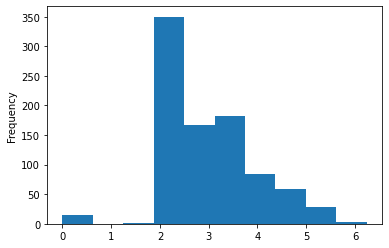

In [ ]:
#Reexpressar Fare para aliviar outliers
def log_tranform(x):
    return np.log(1 + x)
train_pp_df['LogFare']=train_pp_df['Fare'].map(lambda x: log_tranform(x))
train_pp_df["LogFare"].plot(kind="hist")

In [ ]:
# Idade Categórico
train_pp_df["Age_cat"] = pd.cut(train_pp_df["Age"], bins=[0, 5, 14, 25, 45, 99], labels=["BB", "Cri", "Jov", "Adul", "MaisVelhos"])

In [ ]:
# Sem Parentes
def sem_parentes(Age, Parch, SibSp):
  if Parch == 0 and SibSp == 0:
    return "SemParentes" 
  return "ComParentes"
train_pp_df["SemParentes"] = train_pp_df.apply(lambda row: sem_parentes(row.Age, row.Parch, row.SibSp), axis=1)

### Resultado

Adicionados:

```
['Title', 'Deck', 'Family_Size', 'LogFare', 'Age_cat', 'SemParentes']
```

In [ ]:
train_pp_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size,LogFare,Age_cat,SemParentes
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,1,2.110213,Jov,ComParentes
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,1,4.280593,Adul,ComParentes
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,0,2.188856,Adul,SemParentes
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,1,3.990834,Adul,ComParentes
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,0,2.202765,Adul,SemParentes
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr,NaN,0,2.246893,NaN,SemParentes
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,E,0,3.967694,MaisVelhos,SemParentes
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,NaN,4,3.094446,BB,ComParentes
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs,NaN,2,2.495954,Adul,ComParentes
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs,NaN,1,3.436268,Cri,ComParentes


In [ ]:
train_pp_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
Deck           687
Family_Size      0
LogFare          0
Age_cat        177
SemParentes      0
dtype: int64

In [ ]:
for col in train_pp_df:
    col_unique = len(train_pp_df[col].unique())
    print(f"{col}  # unique: {col_unique}")

PassengerId  # unique: 891
Survived  # unique: 2
Pclass  # unique: 3
Name  # unique: 891
Sex  # unique: 2
Age  # unique: 89
SibSp  # unique: 7
Parch  # unique: 7
Ticket  # unique: 681
Fare  # unique: 248
Cabin  # unique: 148
Embarked  # unique: 4
Title  # unique: 4
Deck  # unique: 9
Family_Size  # unique: 9
LogFare  # unique: 248
Age_cat  # unique: 6
SemParentes  # unique: 2


### Nulos, Encodings e Normalizações em Pipeline
* Remover Id, Name, Ticket, Cabin 
* Nulos 
  * Age substituir por média same title
  * Embarked Moda (S)
  * Deck nova classe (NoInfo)
* OneHot = Sex, Embarked, Title, Deck, Age_cat, SemParentes
* SScale = Pclass, Age, Fare, LogFare, SibSp, Parch e Family_Size


In [ ]:
class PandasTranformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self  
  def transform(self, X):
    assert isinstance(X, pd.DataFrame)
    #Title
    X["Title"]=X['Name'].map(lambda x: substrings_in_string(x, TITLE_LIST))
    X["Title"] = X.apply(replace_titles, axis=1)

    #Deck
    X["Deck"]=X['Cabin'].map(lambda x: substrings_in_string(x, CABIN_LIST))

    #Nulos
    X['Age'] = X.Age.fillna(X.groupby('Title')['Age'].transform('mean'))
    values = {"Embarked": "S", "Deck": "NoInfo"}
    X = X.fillna(value=values)
    
    #Outros Atributos
    X["Family_Size"]=X['SibSp']+X['Parch']
    X["LogFare"]=X['Fare'].map(lambda x: log_tranform(x))
    X["Age_cat"] = pd.cut(X["Age"], bins=[0, 5, 14, 18, 45, 99], labels=["BB", "Cri", "Jov", "Adul", "MaisVelhos"])
    X["SemParentes"] = train_pp_df.apply(lambda row: sem_parentes(row.Age, row.Parch, row.SibSp), axis=1)

    #Drop
    X = X.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Fare"])
    return X

In [ ]:
cat_atribs = ["Sex","Embarked", "Deck", "Age_cat", "SemParentes"] 
num_atribs = ["Pclass","Age", "LogFare", "SibSp", "Parch", "Family_Size"]

cat_pipeline = Pipeline([('cat_imputer', SimpleImputer(strategy="most_frequent")),
                         ('one_hot', OneHotEncoder())])

num_pipeline = Pipeline([('num_imputer', SimpleImputer(strategy="mean")),
                         ('scaler', MinMaxScaler())])

cat_num_pipeline = ColumnTransformer([
        ('cat_pipeline', cat_pipeline, cat_atribs),
        ('num_pipeline', num_pipeline, num_atribs)
])

full_pipeline = Pipeline([("pandas_transformations", PandasTranformer()), ("cat_num_pipe", cat_num_pipeline)])

In [ ]:
#Separar X e Y
train_pipe_df = train_df_kaggle.copy()
Y = train_pipe_df["Survived"]
train_pipe_df = train_pipe_df.drop(columns=["Survived"])

In [ ]:
#Aplicar Pipeline - Fit e Transform
X = full_pipeline.fit_transform(train_pipe_df)

## Explorar Modelos
Explorando os modelos com validação cruzada kfold(10 folds)
Utilizando média e desvio padrão do f1 score em cada fold.  

In [ ]:
results = {}

In [ ]:
def display_scores(scores):
  mean = scores.mean()
  std =  scores.std()
  max =  scores.max()
  min =  scores.min()

  print("Scores:", scores)
  print("Mean:",mean)
  print("Standard deviation:",std)
  return mean, std, max, min

In [ ]:
%%time
nome = "LogisticRegression"
model = LogisticRegression()
scores = cross_val_score(model, X, Y, scoring="f1", cv=10)
mean, std , max, min = display_scores(scores)
results[nome] = (mean, std, max, min)

Scores: [0.73239437 0.76056338 0.70967742 0.82191781 0.76056338 0.71875
 0.72131148 0.74193548 0.78787879 0.79411765]
Mean: 0.7549109748552996
Standard deviation: 0.035122404491892745
CPU times: user 340 ms, sys: 306 ms, total: 647 ms
Wall time: 393 ms


In [ ]:
%%time
nome = "SVM"
model = svm.SVC()
scores = cross_val_score(model, X, Y, scoring="f1", cv=10)
mean, std , max, min = display_scores(scores)
results[nome] = (mean, std, max, min)

Scores: [0.74626866 0.74626866 0.6440678  0.81690141 0.8        0.73015873
 0.75409836 0.6779661  0.85294118 0.79411765]
Mean: 0.7562788534532504
Standard deviation: 0.05997803235802241
CPU times: user 396 ms, sys: 62 ms, total: 458 ms
Wall time: 395 ms


In [ ]:
%%time
nome = "KNeighborsClassifier"
model = KNeighborsClassifier()
scores = cross_val_score(model, X, Y, scoring="f1", cv=10)
scores_agg = display_scores(scores)
results[nome] = scores_agg

Scores: [0.70769231 0.65625    0.61016949 0.77777778 0.84848485 0.73015873
 0.74576271 0.73015873 0.81818182 0.75757576]
Mean: 0.7382212173419801
Standard deviation: 0.06687787867521275
CPU times: user 147 ms, sys: 117 ms, total: 264 ms
Wall time: 143 ms


In [ ]:
%%time
nome = "RandomForestClassifier"
model = RandomForestClassifier()
scores = cross_val_score(model, X, Y, scoring="f1", cv=10)
scores_agg = display_scores(scores)
results[nome] = scores_agg

Scores: [0.6969697  0.75362319 0.6557377  0.81578947 0.82352941 0.74626866
 0.68852459 0.625      0.82857143 0.7761194 ]
Mean: 0.7410133554179299
Standard deviation: 0.06849218479414869
CPU times: user 2.36 s, sys: 88.8 ms, total: 2.44 s
Wall time: 2.38 s


In [ ]:
%%time
nome = "DecisionTreeClassifier"
model = DecisionTreeClassifier()
scores = cross_val_score(model, X, Y, scoring="f1", cv=10)
scores_agg = display_scores(scores)
results[nome] = scores_agg

Scores: [0.66666667 0.60869565 0.63492063 0.75       0.73972603 0.75757576
 0.72131148 0.63636364 0.82191781 0.82857143]
Mean: 0.7165749087298311
Standard deviation: 0.07363905070560678
CPU times: user 55.7 ms, sys: 3.04 ms, total: 58.7 ms
Wall time: 58 ms


In [ ]:
%%time
nome = "XGBClassifier"
model = XGBClassifier()
scores = cross_val_score(model, X, Y, scoring="f1", cv=10)
scores_agg = display_scores(scores)
results[nome] = scores_agg

Scores: [0.70769231 0.72131148 0.65517241 0.82191781 0.84375    0.77419355
 0.77419355 0.6984127  0.87323944 0.78125   ]
Mean: 0.7651133236921035
Standard deviation: 0.06578660804201648
CPU times: user 810 ms, sys: 7.86 ms, total: 818 ms
Wall time: 822 ms


In [ ]:
pd.DataFrame(results, index=["metric", "std", "max", "min"]).transpose()

,metric,std,max,min
LogisticRegression,0.754911,0.035122,0.821918,0.709677
SVM,0.756279,0.059978,0.852941,0.644068
KNeighborsClassifier,0.738221,0.066878,0.848485,0.610169
RandomForestClassifier,0.741013,0.068492,0.828571,0.625000
DecisionTreeClassifier,0.716575,0.073639,0.828571,0.608696
XGBClassifier,0.765113,0.065787,0.873239,0.655172


## Aperfeiçoar Modelo

In [ ]:
#Random Search XGB
%%time
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000]}

model_XGB = XGBClassifier()
clf = RandomizedSearchCV(estimator=model_XGB, 
                   param_distributions=params,
                   scoring='f1',
                   verbose=1,
                   n_iter=10,
                   cv=10,
                   refit=True,
                   random_state=42)
clf.fit(X, Y)
best_model = clf.best_estimator_

print("Best parameters:", clf.best_params_)
print("Biggest F1: ", clf.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05}
Biggest F1:  0.7701805627514752
CPU times: user 1min 13s, sys: 987 ms, total: 1min 14s
Wall time: 1min 14s


In [ ]:
#Importância das features
one_hot = full_pipeline.named_steps["cat_num_pipe"].named_transformers_["cat_pipeline"].named_steps["one_hot"].categories_
one_hot = [e for v in one_hot for e in v]
features = one_hot + num_atribs

features_importance = sorted(zip(best_model.feature_importances_, features), reverse=True)
features_importance

[(0.25372717, 'female'),
 (0.21046942, 'Pclass'),
 (0.12437652, 'NoInfo'),
 (0.04720184, 'SibSp'),
 (0.04142612, 'Family_Size'),
 (0.038544517, 'E'),
 (0.03696449, 'S'),
 (0.03258166, 'MaisVelhos'),
 (0.029689021, 'B'),
 (0.024621109, 'Jov'),
 (0.022122014, 'Age'),
 (0.021886814, 'LogFare'),
 (0.021165878, 'BB'),
 (0.020560322, 'Adul'),
 (0.012943901, 'A'),
 (0.011423024, 'ComParentes'),
 (0.010753304, 'C'),
 (0.00944873, 'Parch'),
 (0.009188959, 'C'),
 (0.007961524, 'D'),
 (0.007678591, 'Q'),
 (0.005265045, 'Cri'),
 (0.0, 'male'),
 (0.0, 'T'),
 (0.0, 'SemParentes'),
 (0.0, 'G'),
 (0.0, 'F')]

In [ ]:
#XGB Aprimorado na comparação
nome = "XGBClassifier Search"
scores = cross_val_score(best_model, X, Y, scoring="f1", cv=10)
scores_agg = display_scores(scores)
results[nome] = scores_agg

Scores: [0.76923077 0.81818182 0.63333333 0.82191781 0.8358209  0.72413793
 0.77419355 0.74193548 0.86956522 0.7761194 ]
Mean: 0.7764436208156413
Standard deviation: 0.06361738409668824


In [ ]:
pd.DataFrame(results, index=["metric", "std", "max", "min"]).transpose()

,metric,std,max,min
LogisticRegression,0.770178,0.050712,0.845070,0.677419
SVM,0.770100,0.063953,0.852941,0.666667
KNeighborsClassifier,0.752440,0.065326,0.835821,0.590164
RandomForestClassifier,0.739731,0.066898,0.811594,0.622951
DecisionTreeClassifier,0.711850,0.047231,0.771429,0.637681
XGBClassifier,0.771627,0.062350,0.873239,0.644068
XGBClassifier Search,0.776444,0.063617,0.869565,0.633333


## Apresentar Solução

---
**FEATURES ADICIONADAS**
*   ['Title', 'Deck', 'Family_Size', 'LogFare', 'Age_cat', 'SemParentes']

---
**IMPORTANCIA FEATURES**
*   Sexo é realmente mais influente. Encapsulado no Título.
*   Classe do bilhete importa.
*   Deck, Family Size,  parece importar.

---
**MODELOS**
*   XGBoost melhor modelo, seguido pelo LogisticRegression.
*   XGBoost aprimorado com RandomSearch. Melhores Parâmetros = ({'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05})
*   Comparação entre médias de f1-score. Cross-validation com 10 folds.  

---
**SUBMISSÃO**
*   Accuracy public = 0.77511
*   Rank = 7783

---
**POSSÍVEIS MELHORIAS**
*   Mais buscas de parâmetros.
*   Limpar features.
*   Expandir Título.
*   Buscar prefixos no Ticket.



In [ ]:
test_pipe_df = test_df_kaggle.copy()
#Aplicar Pipeline - Transform
X_test = full_pipeline.transform(test_pipe_df)
Y_pred = clf.predict(X_test)

In [ ]:
submission = pd.DataFrame([test_pipe_df.PassengerId, Y_pred], index=["PassengerId","Survived"]).transpose()
submission.to_csv("sub.csv", index=False)